In [ ]:
%pip install numpy
%pip install pandas
%pip install tensorflow
%pip install seaborn
%pip install plotly
%pip install scikit-learn
%pip install nltk
%pip install cufflinks
%pip install imbalanced-learn
%pip install wordcloud
%pip install textblob
%pip install contractions

In [1]:
# basic imports
import re
import string
import numpy as np
import pandas as pd
import sys

# dataset manipulation
from sklearn import datasets
from itertools import cycle
from sklearn import preprocessing
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# preprocessing
import nltk
import contractions
from nltk.tokenize import word_tokenize
nltk.download("stopwords")
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))
from textblob import TextBlob
from imblearn.over_sampling import SMOTE
from collections import defaultdict
from nltk.stem import WordNetLemmatizer, SnowballStemmer
stemmer = SnowballStemmer("english")
nltk.download("punkt")
nltk.download('wordnet')
from sklearn.preprocessing import label_binarize

# vectorizers - featue extraction
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# model imports
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm
from sklearn.svm import SVC

# evaluation
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, average_precision_score

# visualisation
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from wordcloud import WordCloud, STOPWORDS
from plotly import tools
from plotly.offline import iplot
import cufflinks as cf
# from scipy import interp

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Janmesh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Janmesh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Janmesh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# import and view the dataset
df = pd.read_csv('datasets/train.csv', names=["sentiment", "title", "review"])
df.head(5)

,sentiment,title,review
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,2,Amazing!,This soundtrack is my favorite music of all ti...
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."


In [3]:
# import and view the test dataset
df_test = pd.read_csv("datasets/test.csv", names=["sentiment", "title", "review"])
df_test.head(5)

,sentiment,title,review
0,2,Great CD,My lovely Pat has one of the GREAT voices of h...
1,2,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
2,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
3,2,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...
4,2,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600000 entries, 0 to 3599999
Data columns (total 3 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   sentiment  int64 
 1   title      object
 2   review     object
dtypes: int64(1), object(2)
memory usage: 82.4+ MB


In [5]:
df.describe()

,sentiment
count,3600000.0
mean,1.5
std,0.5
min,1.0
25%,1.0
50%,1.5
75%,2.0
max,2.0


In [6]:
# stratified sampling the dataset with class balance
#df = df.sample(100000, axis=0)
#df_test = df_test.sample(10000, axis=0)

<Axes: ylabel='count'>

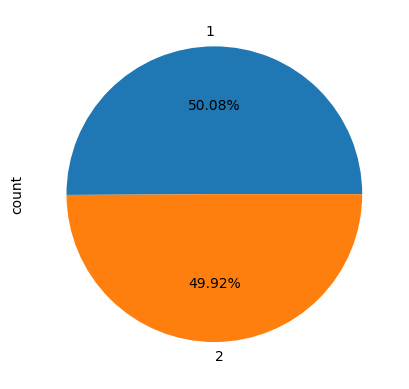

In [7]:
df["sentiment"].value_counts().plot(kind="pie", autopct='%1.2f%%')

In [8]:
# Data Preparation

def concat_columns(df, col1, col2, new_col):
    df[new_col] = df[col1].apply(str) + ' ' + df[col2].apply(str)
    df.drop(col2, axis = 1, inplace = True)
    return df

df = concat_columns(df, 'review', 'title', 'review')
df_test = concat_columns(df_test, 'review', 'title', 'review')

In [9]:
df.loc[:, "sentiment"] = df["sentiment"].map({1: 0, 2: 1})
df_test.loc[:, "sentiment"] = df_test.sentiment.map({1: 0, 2: 1})
df.loc[:, "review_length"] = df["review"].apply(len)

In [10]:
nltk.downloader.download('vader_lexicon')

analyzer = SentimentIntensityAnalyzer()
def get_nltk_sentiment(text):
    scores = analyzer.polarity_scores(text)
    sentiment = 1 if scores['pos'] > 0 else 0
    return sentiment

def get_TextBlob_sentiment(text):
    score = TextBlob(text).sentiment.polarity
    sentiment = 1 if score > 0 else 0
    return sentiment

df['nltk_sentiment'] = df['review'].apply(get_nltk_sentiment)
df['TB_sentiment'] = df['review'].apply(get_TextBlob_sentiment)

df.loc[:, "subjectivity"] = df["review"].apply(lambda x: TextBlob(x).sentiment.subjectivity)

"""
    - review_length and sentiment are not significantly correlated
    - subjectivity and sentiment are not significantly correlated either
"""

df.describe()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Janmesh\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,sentiment,review_length,nltk_sentiment,TB_sentiment,subjectivity
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000
mean,0.499200,431.13862,0.934630,0.752720,0.530908
std,0.500002,237.99868,0.247179,0.431433,0.151172
min,0.000000,100.00000,0.000000,0.000000,0.000000
25%,0.000000,231.00000,1.000000,1.000000,0.444187
50%,0.000000,383.00000,1.000000,1.000000,0.531250
75%,1.000000,595.00000,1.000000,1.000000,0.620000
max,1.000000,1014.00000,1.000000,1.000000,1.000000


<Axes: >

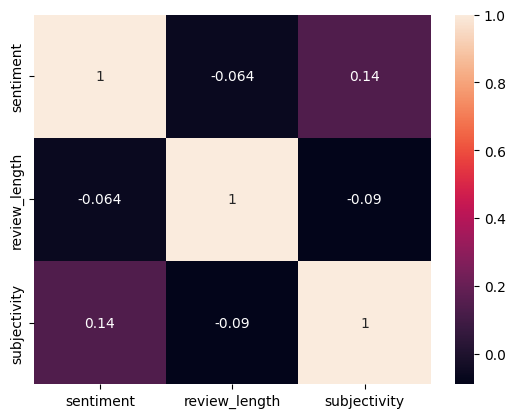

In [11]:
sns.heatmap(data=df.loc[:, ["sentiment", "review_length", "subjectivity"]].corr(), annot=True)

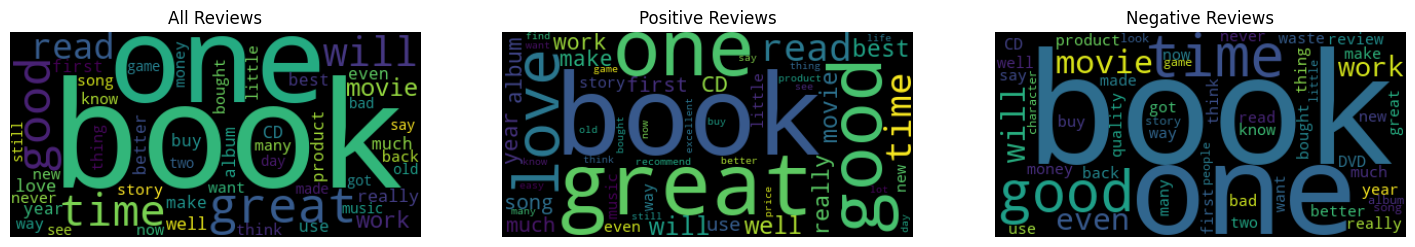

In [12]:
# analysis - EDA
## wordcloud
figure, ax = plt.subplots(1, 3, figsize=(18, 18))
wordcloud = WordCloud(collocations=False, max_words=50).generate(" ".join(df.review.tolist()))
ax[0].axis("off")
ax[0].set_title("All Reviews")
ax[0].imshow(wordcloud, interpolation="bilinear")

pos_wordcloud = WordCloud(collocations=False, max_words=50).generate(" ".join(df.loc[df.sentiment == 1, "review"].tolist()))
ax[1].axis("off")
ax[1].set_title("Positive Reviews")
# ax[1].set_palette("mako")
ax[1].imshow(pos_wordcloud, interpolation="bilinear")

neg_wordcloud = WordCloud(collocations=False, max_words=50).generate(" ".join(df.loc[df.sentiment == 0, "review"].tolist()))
ax[2].axis("off")
ax[2].set_title("Negative Reviews")
ax[2].imshow(neg_wordcloud, interpolation="bilinear")

c:\Users\Janmesh\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\distributions.py:2125: UserWarning:

`displot` is a figure-level function and does not accept the ax= parameter. You may wish to try histplot.

c:\Users\Janmesh\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\distributions.py:2125: UserWarning:

`displot` is a figure-level function and does not accept the ax= parameter. You may wish to try histplot.

c:\Users\Janmesh\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\distributions.py:2125: UserWarning:

`displot` is a figure-level function and does not accept the ax= parameter. You may wish to try histplot.



Text(0.5, 1.0, 'Review Length distribution of Negative Reviews')

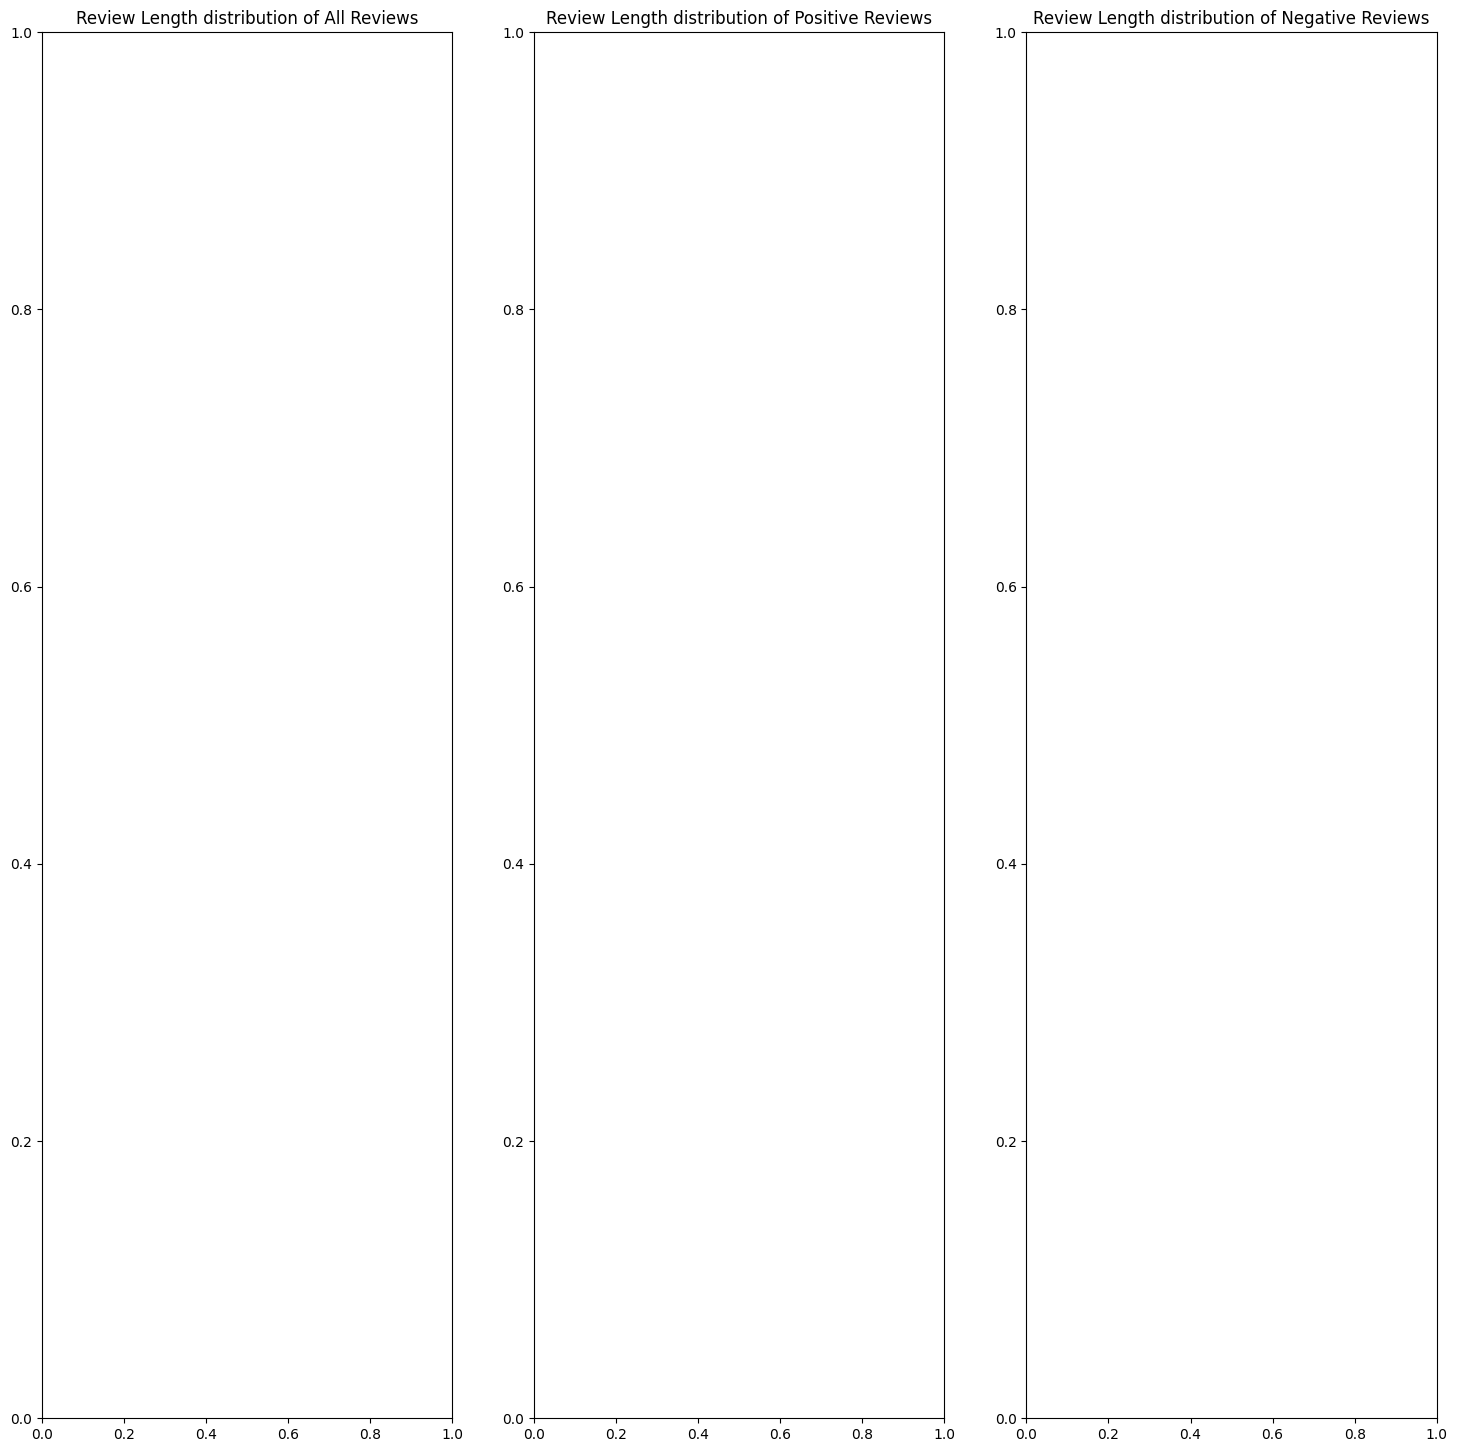

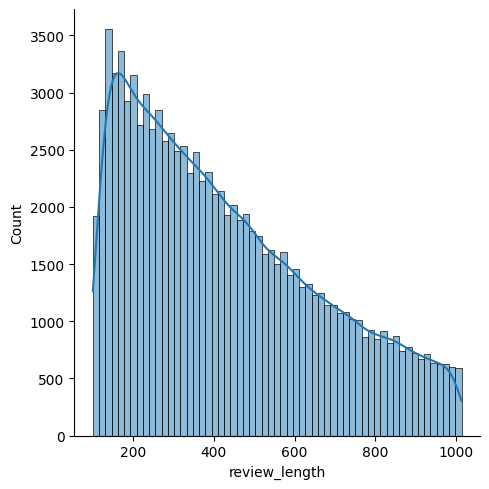

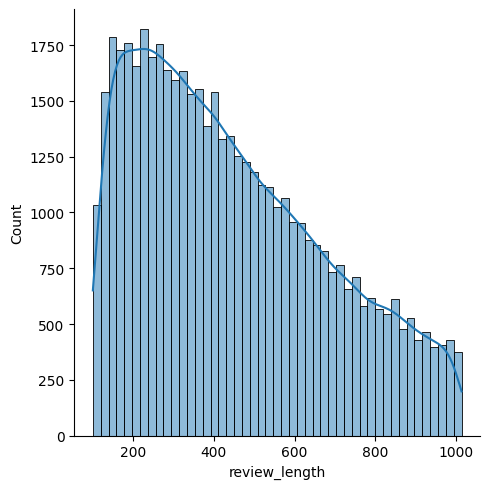

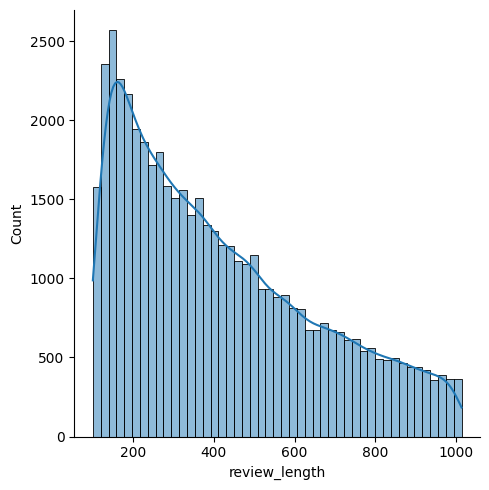

In [13]:
## review length analysis
fig, ax = plt.subplots(1, 3, figsize=(18, 18))
sns.displot(x=df["review_length"], kde=True, ax=ax[0])
ax[0].set_title("Review Length distribution of All Reviews")
sns.displot(x=df.loc[df.sentiment == 0, "review_length"], kde=True, ax=ax[1])
ax[1].set_title("Review Length distribution of Positive Reviews")
sns.displot(x=df.loc[df.sentiment == 1, "review_length"], kde=True, ax=ax[2])
ax[2].set_title("Review Length distribution of Negative Reviews")

<Axes: xlabel='review_length', ylabel='Proportion'>

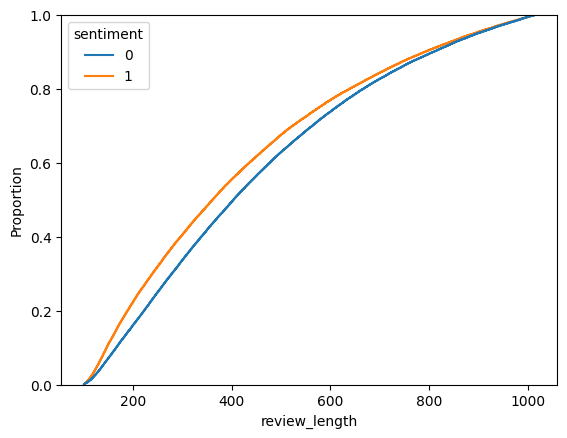

In [14]:
## review length analysis
sns.ecdfplot(data=df, x="review_length", hue="sentiment")

In [15]:
# text cleaning

# Trial 3
def clean_text(text):
    # Remove special characters and numbers
    text = re.sub(r'[^A-Za-zÀ-ú ]+', '', text)
    # Analyzing the most used words below, i chose to exclude these because there are too many and are unnecessary
    text = re.sub('book|one', '', text)
    # Convert to lower case
    text = text.lower()
    # remove scores
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def remove_stopwords(texto):
    stop_words = set(stopwords.words('english'))
    tokens = nltk.word_tokenize(texto.lower())
    return " ".join([token for token in tokens if token not in stop_words])

def normalize_text(text):
    stemmer = SnowballStemmer("english")
    normalized_text = []
    for word in text.split():
        stemmed_word = stemmer.stem(word)
        normalized_text.append(stemmed_word)
    return ' '.join(normalized_text)

In [16]:
tdf = df
tdf.loc[:, "review"] = tdf["review"].apply(clean_text)
tdf.loc[:, "review"] = tdf["review"].apply(remove_stopwords)
tdf.loc[:, "review"] = tdf["review"].apply(normalize_text)

tdf.head(5)

,sentiment,review,review_length,nltk_sentiment,TB_sentiment,subjectivity
2544183,0,suppos part biographi part person recollect pa...,496,0,1,0.553968
1064201,1,love movi favorit movi went see movi movi thea...,548,1,1,0.677886
1802606,1,keep read youv finish descript tennesse landsc...,176,1,1,0.833333
3565842,0,read articl john clare john lanchest new yorke...,819,1,1,0.440404
815396,0,kindergarten first chapter given exchang impre...,559,1,1,0.467740


In [17]:
df_test.loc[:, "review"] = df_test["review"].apply(clean_text)
df_test.loc[:, "review"] = df_test["review"].apply(remove_stopwords)
df_test.loc[:, "review"] = df_test["review"].apply(normalize_text)

df_test.head(5)

,sentiment,review
239171,0,photo mislead old silver wrapper condom new bl...
367659,0,hii dell xps laptop sure buy review thought go...
346470,1,like album lot first heard song sunset come co...
86253,0,must worst product ever reciev amazon believ n...
218917,1,love posat view express love angri way check g...


In [18]:
# analysis on clean text
print(tdf.review_length.max())

1014


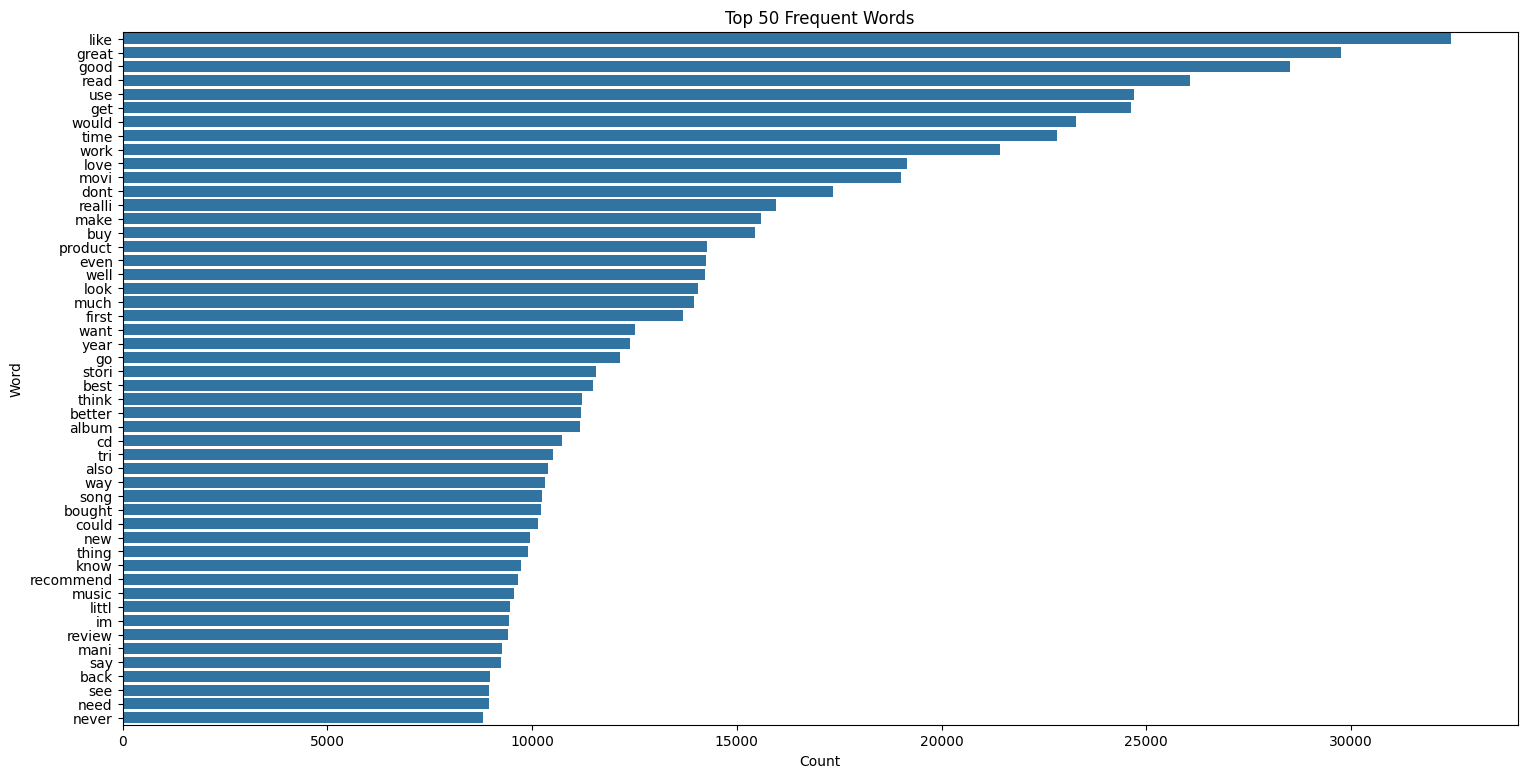

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate word frequency
all_sentences = " ".join(tdf.review)
all_words = all_sentences.split()
word_counts = pd.Series(all_words).value_counts()
word_df = pd.DataFrame({'word': word_counts.index, 'count': word_counts.values})

# Plot number of unique words
plt.figure(figsize=(18, 9))
sns.barplot(data=word_df.head(50), y="word", x="count", orient='h')
plt.title('Top 50 Frequent Words')
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()

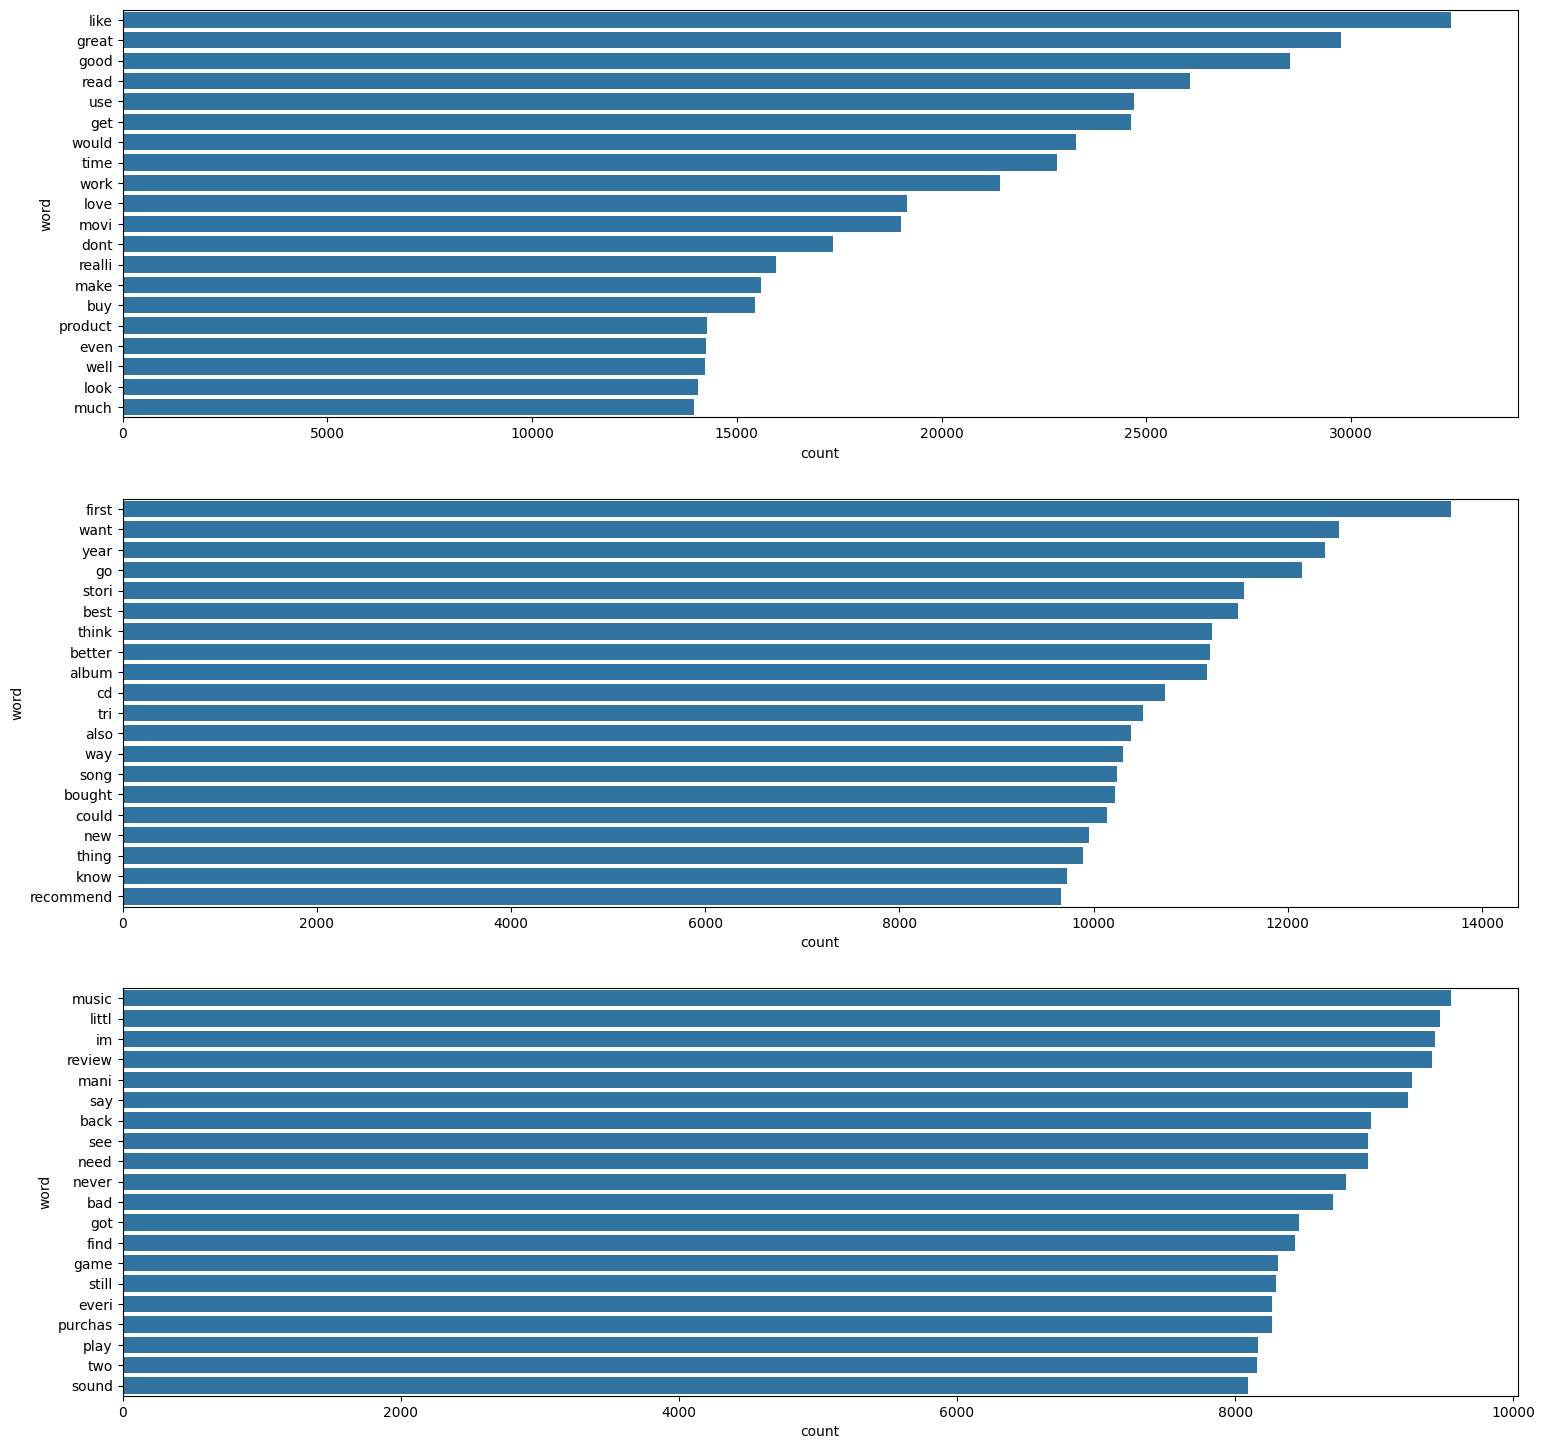

In [20]:
# Plot top 100 unigrams in 3 subplots
fig, ax = plt.subplots(3, figsize=(18, 18))
for i in range(3):
    start_index = i * 20
    end_index = (i + 1) * 20
    sns.barplot(data=word_df.iloc[start_index:end_index], y="word", x="count", orient='h', ax=ax[i])
plt.show()

In [21]:
# no. of unique words
word_df.shape

(144092, 2)

Best value of n: 1


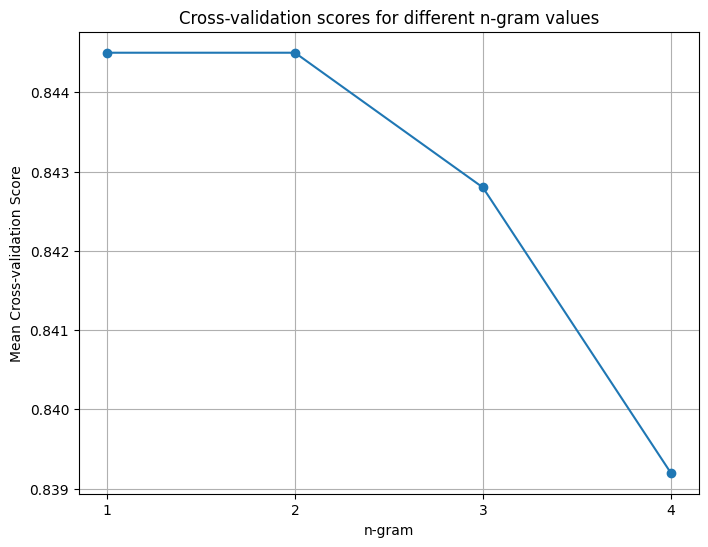

In [22]:
# n-gram analysis

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import numpy as np

sample_text = tdf.sample(10000)
# transformed_text = tdf.iloc[:100].apply(lambda x: x.review.lower())
# Tokenize text data (assume X_train contains text data)
tokenized_text = [text.split() for text in tdf.review.tolist()]

# Initialize lists to store cross-validation scores for different n-gram values
cv_scores = []

# Try different values of n for n-grams
n_values = [n for n in range(1, 5)]  # Example: Try unigrams, bigrams, trigrams, and quadgrams
for n in n_values:
    # Generate n-grams
    ngram_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, n))
    X_ngrams = ngram_vectorizer.fit_transform(sample_text.review.tolist())
    
    # Initialize classification model (example: Logistic Regression)
    model = LogisticRegression(max_iter=20000)
    
    # Perform cross-validation
    scores = cross_val_score(model, X_ngrams, sample_text.sentiment, cv=5)  # 5-fold cross-validation
    cv_scores.append(np.mean(scores))

# Find the best value of n
best_n_index = np.argmax(cv_scores)
best_n = n_values[best_n_index]
print(f"Best value of n: {best_n}")

# Plot cross-validation scores for different n-gram values
plt.figure(figsize=(8, 6))
plt.plot(n_values, cv_scores, marker='o', linestyle='-')
plt.title('Cross-validation scores for different n-gram values')
plt.xlabel('n-gram')
plt.ylabel('Mean Cross-validation Score')
plt.xticks(n_values)
plt.grid(True)
plt.show()

Best value of n: 20000


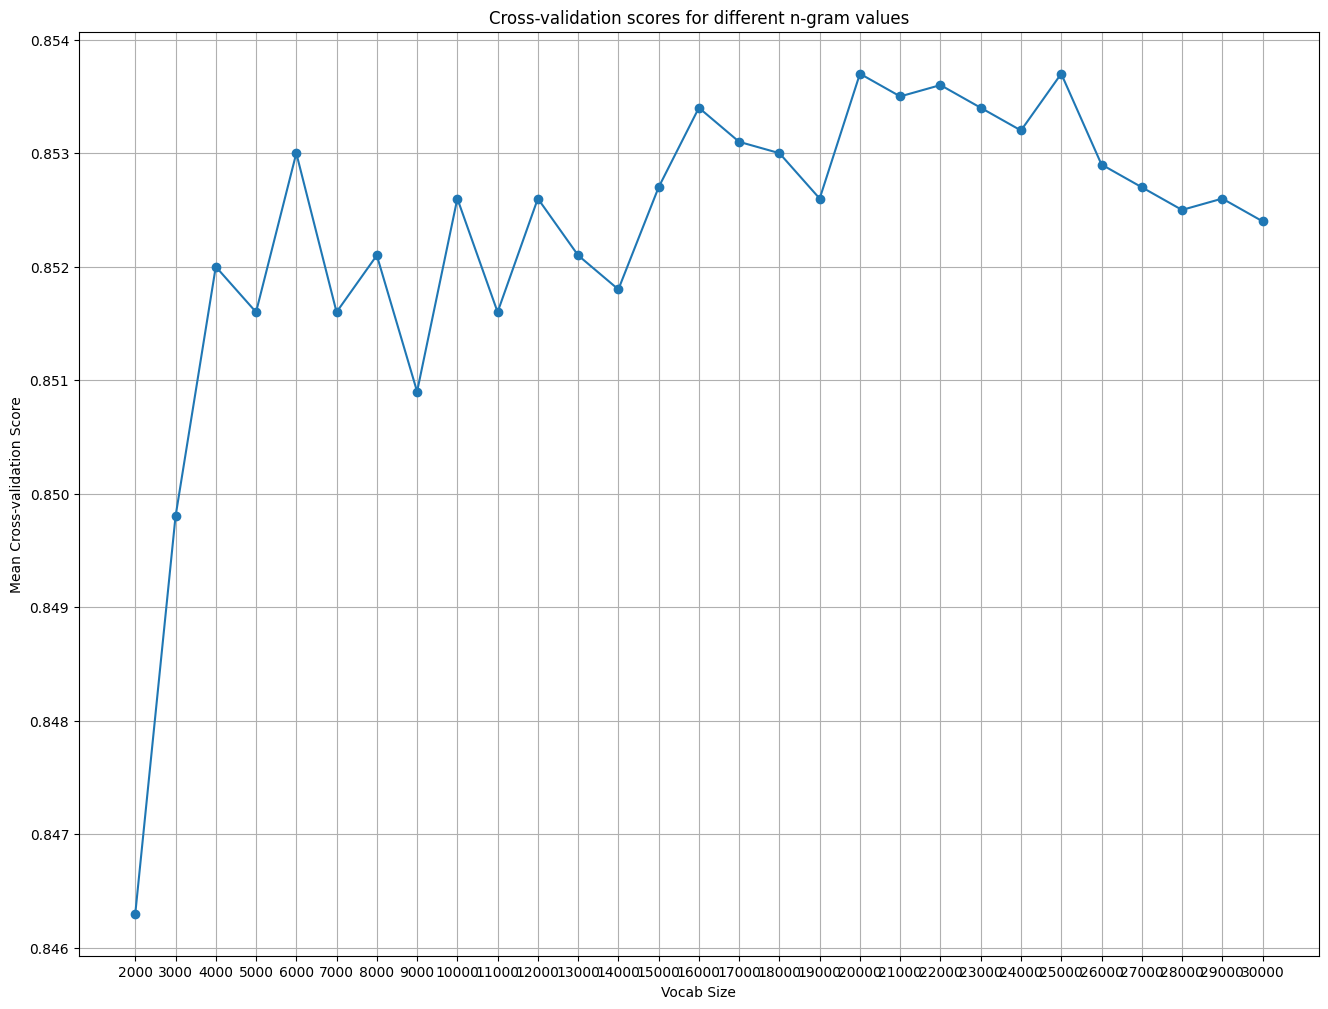

In [23]:
# Optimum feature extraction
sample_text = tdf.sample(10000)
vocab_sizes = [n for n in range(2000, 30001, 1000)]  # Example: Try vocabulary values in steps of 1000

vocab_cv_scores = []

for n in vocab_sizes:
    # Generate n-grams
    vocab_vectorizer = TfidfVectorizer(max_features=n, analyzer='word', ngram_range=(1, 3))
    X_wfeatures = vocab_vectorizer.fit_transform(sample_text.review.tolist())
    
    # Initialize classification model (example: Logistic Regression)
    model = LogisticRegression(max_iter=20000)
    
    # Perform cross-validation
    scores = cross_val_score(model, X_wfeatures, sample_text.sentiment, cv=5)  # 5-fold cross-validation
    vocab_cv_scores.append(np.mean(scores))

# Find the best value of n
best_n_index = np.argmax(vocab_cv_scores)
best_n = vocab_sizes[best_n_index]
print(f"Best value of n: {best_n}")

# Plot cross-validation scores for different n-gram values
plt.figure(figsize=(16, 12))
plt.plot(vocab_sizes, vocab_cv_scores, marker='o', linestyle='-')
plt.title('Cross-validation scores for different n-gram values')
plt.xlabel('Vocab Size')
plt.ylabel('Mean Cross-validation Score')
plt.xticks(vocab_sizes)
plt.grid(True)
plt.show()

In [24]:
vectorizer = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 1),
    analyzer='word',
    use_idf=True
)

In [25]:
# Cluster analysis
# KNN

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
import numpy as np

x_train_sample = tdf.sample(5000)
# corpus = X_train.tolist()
xtrain_vec_sample = vectorizer.fit_transform(x_train_sample.review)
# Initialize KNN model
k = 2  # Number of clusters
knn = NearestNeighbors(n_neighbors=k, algorithm='brute', metric='cosine')
knn.fit(xtrain_vec_sample)

# Predict cluster labels
distances, indices = knn.kneighbors(xtrain_vec_sample)

# Fit PCA to reduce the dimensionality of TF-IDF features to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(xtrain_vec_sample.toarray())

In [26]:
pca.explained_variance_

array([0.00551348, 0.00487598])

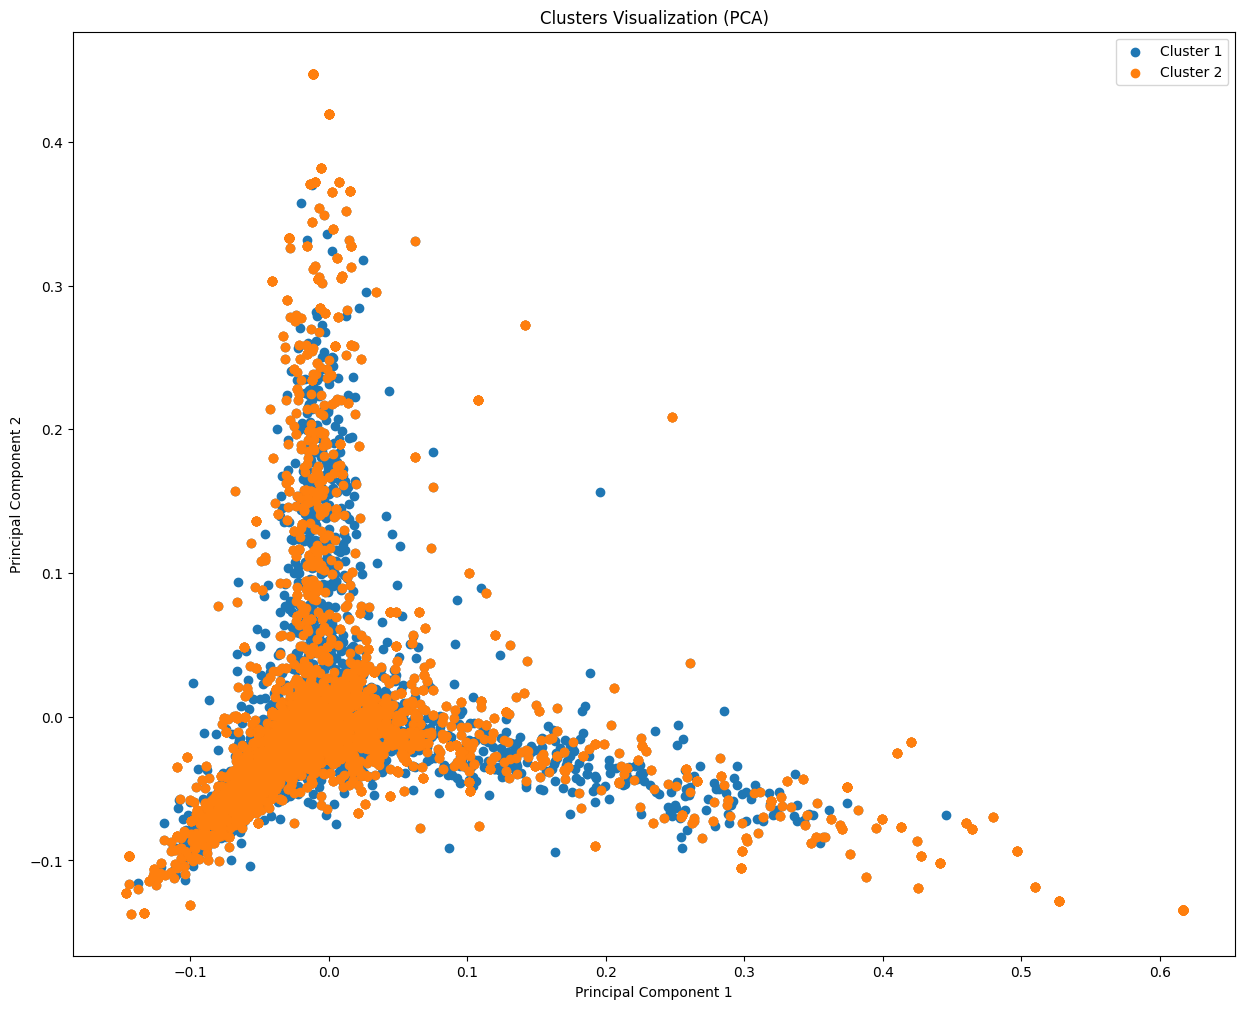

In [27]:
# Plot clusters with smaller figure size
plt.figure(figsize=(15, 12))  # Adjust the figure size as needed
for i in range(2):  # Plot only the clusters (assuming k=2)
    cluster_indices = indices[:, i]
    cluster_points = X_pca[cluster_indices]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i+1}')

plt.title('Clusters Visualization (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

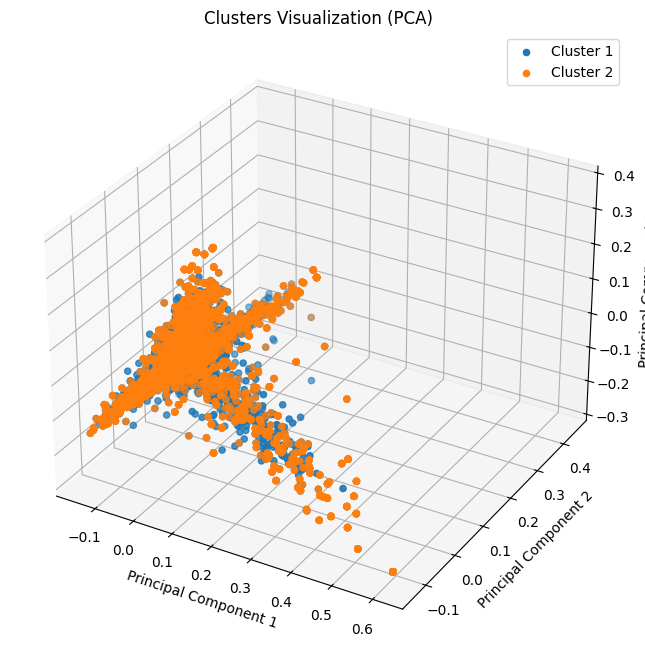

In [28]:
from mpl_toolkits.mplot3d import Axes3D

# Fit PCA to reduce the dimensionality of TF-IDF features to 3 dimensions
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(xtrain_vec_sample.toarray())

# Plot clusters in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for i in range(2):  # Plot only the clusters (assuming k=2)
    cluster_indices = indices[:, i]
    cluster_points = X_pca_3d[cluster_indices]
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], label=f'Cluster {i+1}')

ax.set_title('Clusters Visualization (PCA)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.legend()
plt.show()

In [29]:
vectorizer = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 1),
    analyzer='word',
    use_idf=True
)

In [30]:
# train test split (80 / 20)
# X_train, X_test, y_train, y_test = train_test_split(tdf.review, tdf.sentiment, test_size=0.2, random_state=1)
X_train, y_train = tdf.review, tdf.sentiment
X_test, y_test = df_test.review, df_test.sentiment

In [31]:
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [32]:
# Logistic Regression

# baseline model
LRmodel = LogisticRegression(max_iter=20000)
LRmodel.fit(X_train_vec, y_train)

"""Logistic Regression"""

y_pred_lr = LRmodel.predict(X_test_vec)
LRcf = confusion_matrix(y_test, y_pred_lr)
print(LRcf)
print(accuracy_score(y_test, y_pred_lr))

acc = accuracy_score(y_pred_lr, y_test)
report = classification_report(y_test, y_pred_lr)
roc = roc_auc_score(y_test,y_pred_lr)
print(f"Accuracy: {acc*100}% and Roc Auc Score:{roc_auc_score(y_test,y_pred_lr)}")
print(report)

[[4410  666]
 [ 582 4342]]
0.8752
Accuracy: 87.52% and Roc Auc Score:0.8752988690507055
              precision    recall  f1-score   support

           0       0.88      0.87      0.88      5076
           1       0.87      0.88      0.87      4924

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [33]:
# SVM
from sklearn.svm import LinearSVC

# Initialize the classifier
svm = LinearSVC()

# Train the classifier
svm.fit(X_train_vec, y_train)

"""Support Vector Machine"""

# store predictions in y_pred_svm
y_pred_svm = svm.predict(X_test_vec)
SVMcf = confusion_matrix(y_test, y_pred_svm)
print(SVMcf)
print(accuracy_score(y_test, y_pred_svm))

c:\Users\Janmesh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



[[4372  704]
 [ 621 4303]]
0.8675


In [34]:
RFmodel = RandomForestClassifier(n_estimators=100, random_state=42)  # Adjust n_estimators for best results
RFmodel.fit(X_train_vec, y_train)

# Make predictions on new data (assuming a new dataframe 'new_df' with text column)
y_pred_rf = RFmodel.predict(X_test_vec)
RFcf = confusion_matrix(y_test, y_pred_rf)
print(RFcf)
print(accuracy_score(y_test, y_pred_rf))

acc = accuracy_score(y_pred_rf, y_test)
report = classification_report(y_test, y_pred_rf)
roc = roc_auc_score(y_test,y_pred_rf)
print(f"Accuracy: {acc*100}% and Roc Auc Score:{roc_auc_score(y_test,y_pred_rf)}")
print(report)

[[4358  718]
 [ 769 4155]]
0.8513
Accuracy: 85.13% and Roc Auc Score:0.851188098498277
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      5076
           1       0.85      0.84      0.85      4924

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



([<matplotlib.axis.XTick at 0x2049bba75c0>,
 [Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20')])

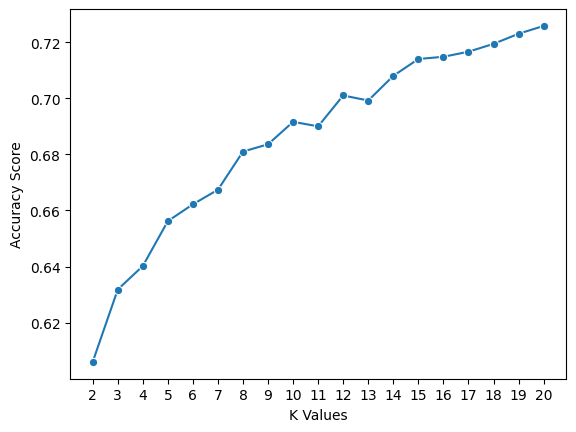

In [35]:
# KNN
knn_c = KNeighborsClassifier(n_neighbors=2)
knn_c.fit(X_train_vec, y_train)

k_values = [i for i in range (2,21)]
scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, xtrain_vec_sample, x_train_sample.sentiment, cv=5)
    scores.append(np.mean(score))
    
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")
plt.xticks(range(2,21))

In [36]:
# finalize knn model
best_index = np.argmax(scores)
best_k = k_values[best_index]
print(f"Best clustering could be observed when there were {best_k} neighbors in KNN.")

"""If best_k != 2 then KNN is insufficient to classify positive/negative reviews"""
knn_c = KNeighborsClassifier(n_neighbors=2)
knn_c.fit(X_train_vec, y_train)

"""KNN"""

y_pred_knn = knn_c.predict(X_test_vec)
KNNcf = confusion_matrix(y_test, y_pred_knn)
print(KNNcf)
print(accuracy_score(y_test, y_pred_knn))

Best clustering could be observed when there were 20 neighbors in KNN.
[[4080  996]
 [2606 2318]]
0.6398


In [40]:
# Bidirectional LSTM

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, Dropout, Embedding, LSTM, SpatialDropout1D, Dense, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Maximum number of words to be considered in the vocabulary
max_words = 20000 
# Maximum number of tokens in a sequence
max_len = int(round(tdf.review_length.max())) 
# Tokenizer
tokenizer = Tokenizer(num_words = max_words) 
# Snap tokenizer to text data
tokenizer.fit_on_texts(X_train) 
# Converts texts into strings of numbers
X_train_seq = tokenizer.texts_to_sequences(X_train) 
X_test_seq = tokenizer.texts_to_sequences(X_test)
# Mapping words to indexes
word_index = tokenizer.word_index 

# convert text to sequences
# X_train_seq = tokenizer.texts_to_sequences(X_train)
# X_test_seq = tokenizer.texts_to_sequences(X_test)

# pad sequences
# max_len = int(round(tdf.review_length.mean())) + 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# convert labels to NumPy arrays and pad with zeros
# y_train = np.array(y_train)
# y_train = np.pad(y_train, (0, X_train_pad.shape[0] - y_train.shape[0]), mode='constant')

# create modified RNN model
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Embedding(1000 , 16),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16 , return_sequences=  True)) ,
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(512 , activation = 'relu'),
#     tf.keras.layers.Dense(1 , activation = 'sigmoid')
# ])

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(max_words, 128),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)) ,
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32 , activation = 'relu'),
    tf.keras.layers.Dense(1 , activation = 'sigmoid')
])

# model = tf.keras.Sequential()
# model.add(Embedding(max_words, 16, input_length = max_len))
# model.add(GlobalAveragePooling1D())
# model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# train modified model
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
history = model.fit(X_train_pad, y_train, epochs=10, batch_size=64, validation_data=(X_test_pad, y_test), callbacks=[early_stop])

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1872s 1s/step - accuracy: 0.8099 - loss: 0.3904 - val_accuracy: 0.8758 - val_loss: 0.2807
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3112s 2s/step - accuracy: 0.9134 - loss: 0.2204 - val_accuracy: 0.8739 - val_loss: 0.2951
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3563s 2s/step - accuracy: 0.9388 - loss: 0.1593 - val_accuracy: 0.8772 - val_loss: 0.3190
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2952s 2s/step - accuracy: 0.9573 - loss: 0.1178 - val_accuracy: 0.8649 - val_loss: 0.4144
Epoch 4: early stopping


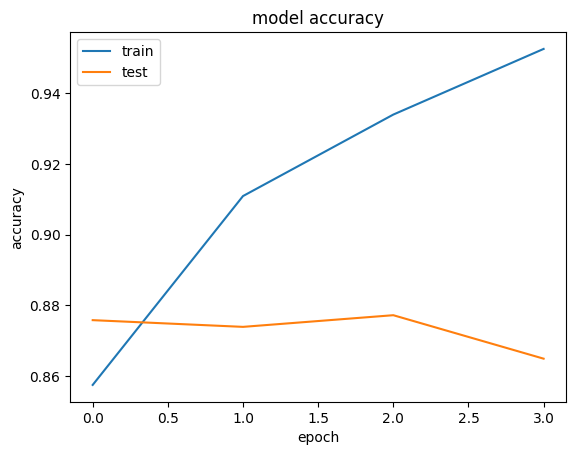

In [41]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

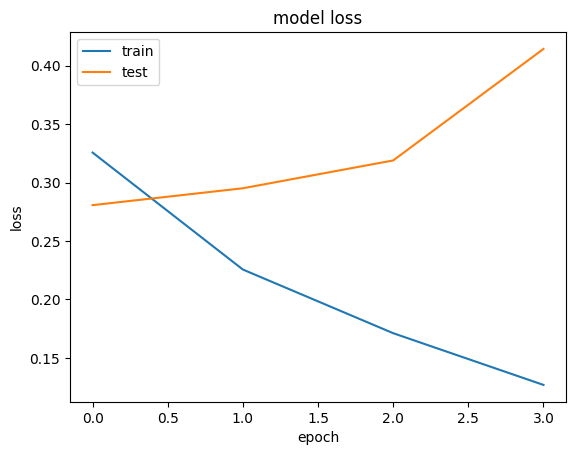

In [42]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()